# University ranks

## Introduction

The goal of this work is to answer the following questions:

* How  do  university  rankings  change  over  time?
* Which  characteristics  of  universities  contribute most to good rankings, or to large changes in the ranking position?
* How do these characteristics correlate with characteristics of cities or countries in which the university islocated?
* Are there predictors for increases or decreases in the rankings?

In the course of this work, these questions will be refined and precised before being answered.

The work is devided in four parts:

* Load the data
* Preprocessing
* Explore and visualise the data
* Model the data


Before starting, we need to load the needed packages for data processing and visualisation:

In [1]:
import os
import numpy as np
import glob
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import re

pd.options.display.max_rows = 5

## Step 1: Load the data

We load the following datasets:
* Ranking datasets: 
    - CWUR (https://www.kaggle.com/mylesoneill/world-university-rankings#cwurData.csv)
    - times (https://www.kaggle.com/mylesoneill/world-university-rankings#timesData.csv)
    - shanghai (https://www.kaggle.com/mylesoneill/world-university-rankings#shanghaiData.csv)
* country properties:
    - public expenditure for education (https://www.kaggle.com/mylesoneill/world-university-rankings#education_expenditure_supplementary_data.csv)
    - hdi (https://www.kaggle.com/tjysdsg/human-development-index#Human%20Development%20Index.csv)
    - corruption perceptions index (https://www.kaggle.com/transparencyint/corruption-index\#history.csv)
    - number of universities per country (https://www.webometrics.info/en/node/54)
    - inhabitants per country (https://data.worldbank.org/indicator/SP.POP.TOTL)
* some mappings:
    - mapping from universities to the corresponding country (https://www.kaggle.com/mylesoneill/world-university-rankings#school_and_country_table.csv)
    - mapping from country to corresponding region (https://www.kaggle.com/fernandol/countries-of-the-world#countries%20of%20the%20world.csv)

In [2]:
datapath = "data/university_data/"

#uni rankings
cwur = pd.read_csv(datapath + "/cwurData.csv", header=0)
shanghai = pd.read_csv(datapath + "/shanghaiData.csv", header=0)
times = pd.read_csv(datapath + "/timesData.csv", header=0)

#additional university information
uni2country = pd.read_csv(datapath + "/school_and_country_table.csv", header=0)

#country properties
educ_expenditure = pd.read_csv(datapath + "/education_expenditure_supplementary_data.csv",
                               header=0,
                               quotechar="\"")
nbupc = pd.read_csv("data/nbupc.tsv", header=0, sep="\t", engine='python')
inh = pd.read_csv("data/inh.csv", header=0, sep=",", quotechar = "\"")
hdi = pd.read_csv(datapath + "/Human_Development_Index.csv")
corruption = pd.read_csv(datapath+ "/history.csv")
countr_reg = pd.read_csv(datapath + "/countries_region.csv")

## Step 2: Preprocessing

Since the data contained missing values and certain columns have different naming schemes it is important to handle those datasets. The goal is to select relevant data, remove or impute missing values and unify the datasets in a way so that they can be merged cleanly.

### 2.1 Removal of irrelevant columns

Certain columns were not needed due to either more data existing in other datasets or the columns being irrelevant.

In [3]:
nbupc = nbupc[["COUNTRY", "ALL"]]
nbupc.columns = ["country", "number of universities"]
nbupc["country"]=nbupc["country"].str.strip()

inh = inh[["Country Name", "2018"]]
inh.columns = ["country", "inhabitants"]

del corruption['Country Code']
del corruption['Region']

countr_reg.drop(countr_reg.columns.difference(['Country','Region']), 1, inplace=True)


shanghai = shanghai[pd.notna(shanghai['university_name'])] #delete one row that is NAs only

### 2.2 Unified Naming of characteristics:

One issue is different naming for certain columns. Analysing and renaming such values is imperative before merging data.

In [4]:
#Rename columns
cwur = cwur.rename(columns={'institution': 'university_name'})
uni2country = uni2country.rename(columns={'school_name': 'university_name'})
countr_reg = countr_reg.rename(columns={'Country': 'country', 'Region': 'region'})
hdi_ref = hdi.rename(columns={'Country': 'country', 'HDI Rank': 'hdi_rank', 'HDI':'hdi'})
corruption_ref = corruption.rename(columns={'CPI 2016 Rank': 'cpi_rank', 'Country': 'country', 'CPI 2012 Score': '2012', 'CPI 2013 Score': '2013', 'CPI 2014 Score': '2014', 'CPI 2015 Score': '2015', 'CPI 2016 Score': '2016'})

#Strip whitespace
hdi_ref['country'] = hdi_ref['country'].str.strip()
educ_expenditure["institute_type"]=educ_expenditure["institute_type"].str.strip()
countr_reg['country'] = countr_reg['country'].str.strip()
countr_reg['region'] = countr_reg['region'].str.strip()
corruption_ref['country'] = corruption_ref['country'].str.strip()

### 2.3 Casting the world_rank columns to int

For visualization and for some ML-algorithms we need to have integer values in the world_rank columns. First, we replace range of numbers by their means, i.e. '200-250' we replace by '225'. Then, there are entries where a symbol is before the number, i.e. '=27' instead of '27'. These symbols we also remove and we are left with a column containing only integer values.

In [5]:
#times[times.world_rank.str.contains('[^0-9]' ,regex = True)]['world_rank'].unique()

#replacing for example '201-250' with mean(201,250)
rangeRanks = times[times.world_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['world_rank'].unique()
rangeRanksToAvg = {}
for ran in rangeRanks:
    parts = ran.split('-')
    avg = int(np.mean([int(parts[0]), int(parts[1])]))
    rangeRanksToAvg[ran] = str(avg)
times = times.replace({"world_rank": rangeRanksToAvg})

rangeRanks = shanghai[shanghai.world_rank.str.contains('[0-9]-[0-9]' ,regex = True)]['world_rank'].unique()
rangeRanksToAvg = {}
for ran in rangeRanks:
    parts = ran.split('-')
    avg = int(np.mean([int(parts[0]), int(parts[1])]))
    rangeRanksToAvg[ran] = str(avg)
shanghai = shanghai.replace({"world_rank": rangeRanksToAvg})

#replacing for example '=127' with 127
times['world_rank'] = times['world_rank'].apply(lambda x : re.sub("[^0-9]", "", str(x)))

times = times.astype({'world_rank': 'int64'})
shanghai = shanghai.astype({'world_rank': 'int64'})

### 2.4 Unified Naming of values

For merging, it is necessary to ensure that the values are referred to by the same names. For that we replace different names for the same thing with a common name (e.g. replace 'United States', 'United States of America' by 'USA')

In [6]:
country_dict = {"Czechia": "Czech Republic",
                 "Hong Kong, China (SAR)":"Hong Kong",
                 "Iran (Islamic Republic of)":"Iran",
                 "Korea (Republic of)" : "South Korea",
                 "Korea, Republic of" : "South Korea",
                 'Republic of Ireland':'Ireland',
                 'Russian Federation':'Russia',
                 'Slovakia':'Slovak Republic',
                 'United States of America':'USA',
                 'Unisted States of America':'USA',
                 "United States" : "USA",
                 'Unted Kingdom':'United Kingdom',
                 'The United States of America': 'USA',
                 'Slovakia': 'Slovak Republic',
                 'Korea (South)': 'South Korea'}


uni_dict = {'ETH Zurich – Swiss Federal Institute of Technology Zurich':'Swiss Federal Institute of Technology in Zurich',
            'University of Michigan':'University of Michigan, Ann Arbor',
            'University of Washington':'University of Washington - Seattle',
            'University of Illinois at Urbana-Champaign':'University of Illinois at Urbana–Champaign',
            'Washington University in St Louis':'Washington University in St. Louis',
            'University of Wisconsin':'University of Wisconsin–Madison',
            'University of Minnesota':'University of Minnesota, Twin Cities',
            'Massachusetts Institute of Technology (MIT)':'Massachusetts Institute of Technology',
            'University of Wisconsin - Madison':'University of Wisconsin–Madison',
            'The University of Tokyo':'University of Tokyo',
            'University of Michigan - Ann Arbor':'University of Michigan, Ann Arbor',
            'The Imperial College of Science, Technology and Medicine':'Imperial College London',
            'Swiss Federal Institute of Technology Zurich':'Swiss Federal Institute of Technology in Zurich',
            'University of Colorado at Boulder':'University of Colorado Boulder',
            'The University of Texas at Austin':'University of Texas at Austin',
            'The University of Texas Southwestern Medical Center at Dallas':'University of Texas Southwestern Medical Center',
            'The University of Edinburgh':'University of Edinburgh'}

cwur = cwur.replace({"country": country_dict})
#shanghai doesn't have country information yet
times = times.replace({"country": country_dict})
uni2country = uni2country.replace({"country": country_dict})
educ_expenditure = educ_expenditure.replace({"country": country_dict})
countr_reg = countr_reg.replace({"country": country_dict})
hdi_ref = hdi_ref.replace({"country": country_dict})
nbupc = nbupc.replace({"country": country_dict})
inh = inh.replace({"country": country_dict})
corruption_ref = corruption_ref.replace({"country":country_dict})

cwur = cwur.replace({"university_name": uni_dict})
shanghai = shanghai.replace({"university_name": uni_dict})
times = times.replace({"university_name": uni_dict})

uni2country = uni2country.replace({"university_name": uni_dict})

### 2.5 Reformatting

Some datasets are structured in a way that they are not easy to merge. For instance some characteristics are arranged as columns instead of rows. On the other hand some rows which are required as columns need to be grouped by classes to be displayed as columns. In this step, the data is restructured so that it is suitable for merging.

#### 2.5.1 Reformat education expenditure dataset

The education expenditure dataset has to be extensively reformatted before working with it, as we need the different years as values in a year column and the different kinds of expenditures should show up in different rows. This is done by the code below. The file was first cleaned manually by deleting the initial spaces of several rows. Furthermore some country names have to be replaced in order to be able to match the country names with the Shanghai ranking

In the next cell, the expenditure dataset is reformatted in a format which is more handy for merging with the rankings. The columns are the types of expenditures and the rows correspond to the percentage of expenditures for a year. While processing the data, we saw that the dataset has many NaN-values, especially concerning the expeditures for non-public institutions. Therefore only the expenditure for public institutions is kept, as the very few data for private institutions has almost no value.

In [7]:
# reformat the dataframe
# first we make a row for each year value and add a year column
years = [1995,2000,2005,2009,2010,2011]

concat_list = []
for year in years:
    cols = ["country","institute_type","direct_expenditure_type", str(year)]
    concat_df = educ_expenditure.copy()[cols]
    concat_df["year"]=year
    concat_df.rename(columns = {str(year) : "percentage of GDP"}, inplace=True)
    concat_list.append(concat_df)

educ_expenditure_processed = pd.concat(concat_list, axis=0, ignore_index=True, sort=False)


# now we transform the values of "institute type" and "direct_expenditure_type" into columns
# so that we obtain a column for each value of "institute_type" and "direct_expenditure_type"
institute_types = set(educ_expenditure_processed["institute_type"])
direct_expenditure_types = set(educ_expenditure_processed["direct_expenditure_type"])

merge_list = []
for institute_type in institute_types:
    for direct_expenditure_type in direct_expenditure_types:
        if direct_expenditure_type == "Public":
            # extract the data with the corresponding "institute_type" and "direct_expenditure_type"

            merge_df =educ_expenditure_processed[(educ_expenditure_processed["institute_type"]==institute_type) & 
                                       (educ_expenditure_processed["direct_expenditure_type"]==direct_expenditure_type)].copy()
            merge_df = merge_df[["country", "year", "percentage of GDP"]]
            merge_df.rename(columns = {"percentage of GDP": "percentage of GDP," + institute_type + " (public)"},
                           inplace=True)
            merge_list.append(merge_df)
            # and store the data separatly

# the data for every single "institute_type" and "direct_expenditure_type" is merged
for merge_df in merge_list[1:]:
    merge_list[0]=merge_list[0].merge(merge_df, on = ["country", "year"])

# take the merged data and set index and multicolumn
educ_expenditure_processed = merge_list[0]
educ_expenditure_processed.set_index(["year", "country"], inplace=True)
educ_expenditure_processed.columns = pd.MultiIndex.from_tuples(
    [(c.split(",")[0], c.split(",")[1]) for c in educ_expenditure_processed.columns]
     )
display(educ_expenditure_processed)

percentage of GDP  \
                  Elementary and Secondary Institutions (public)   
year country                                                       
1995 OECD Average                                            3.5   
     Australia                                               3.2   
...                                                          ...   
2011 Brazil                                                  4.4   
     Russia                                                  2.0   

                                                          \
                  Higher Education Institutions (public)   
year country                                               
1995 OECD Average                                    0.9   
     Australia                                       1.2   
...                                                  ...   
2011 Brazil                                          0.9   
     Russia                                          0.9   

                                             
                  All Institutions (public)  
year country                                 
1995 OECD Average                       4.9  
     Australia                          4.5  
...                                     ...  
2011 Brazil                             5.9  
     Russia                             3.9  

[222 rows x 3 columns]

#### 2.5.2 Reformat Human Development Index

Another goal is to investigate how the human development index affects the rankings, whether a HDI contributes to good rankings or not.
Due to the dataset having the years as columns, it is not feasible to merge it with the CWUR dataset, so those columns are reformatted to rows, with the new column being **year**

In [8]:
hdi_ref = hdi_ref.melt(id_vars=['hdi_rank', 'country'], var_name='year', value_name='hdi')
hdi_ref['year'] = pd.to_numeric(hdi_ref['year'])

#Index to limit data to 2012-2017
hdi_indexed = hdi_ref.set_index(['year', 'country'])
hdi_indexed = hdi_indexed.loc[(slice(2012, 2017))]
hdi_ref = hdi_indexed.reset_index()

#### 2.5.2 Reformat Corruption Perceptions Index

Some kind of corruption measure was planned to be considered. Similar to the HDI dataset, this dataset also contained years as columns and was handled similarly.

In [9]:
corruption_ref = corruption_ref.melt(id_vars=['cpi_rank', 'country'], var_name='year', value_name='cpi_score')
corruption_ref['year'] = pd.to_numeric(corruption_ref['year'])

### 2.6 Missing Data
Several dataset potentially contain missing values. In the following section, such datasets are analysed and handled depending on which and how much data is missing.

#### 2.6.1 Impute CWUR missing data

By analysing how many rows were missing and the correlation to ranking of universities, we came to the conclusion, that multivariate imputation would be an optimal solution here, due to good correlation with other characteristics and only a small amount of rows being required to be imputed, leading to introduction of almost no bias. For instance, we see that *broad_impact* characteristic has a very good correlation with the rankings

CWUR values
world_rank         0
university_name    0
                  ..
score              0
year               0
Length: 14, dtype: int64


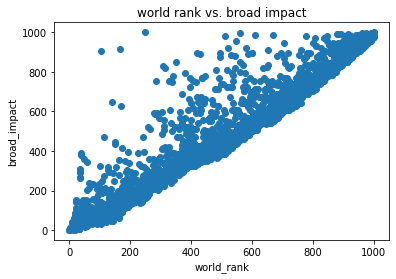

In [10]:
#check missing values in cwur data
print('CWUR values')
print(cwur.isnull().sum())

#First glance at the data suggests, that the missing value column broad impact seems to correlate with world rank
#(imputation likely choice):
plt.scatter(cwur['world_rank'], cwur['broad_impact'])
plt.title('world rank vs. broad impact')
plt.xlabel('world_rank')
plt.ylabel('broad_impact')

#Use Encoder to encode categories (country, institution)
encInst = sk.preprocessing.LabelEncoder().fit(cwur['university_name'])
encCon = sk.preprocessing.LabelEncoder().fit(cwur['country'])

cwur['university_name']  = encInst.transform(cwur['university_name'])
cwur['country'] =  encCon.transform(cwur['country'])

#general cutoff for imputation without introducing bias is 3% of rows contained with missing values -> 
#use multivariate imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(cwur)

cwur_imputed = pd.DataFrame(imp.transform(cwur), columns = cwur.columns)

#keep a copy of encoded labels for purposes
cwur_imputed_enc = cwur_imputed.copy()

#we transform back our label encoding back after imputation
cwur_imputed['country'] = encCon.inverse_transform(cwur['country'])
cwur_imputed['university_name'] = encInst.inverse_transform(cwur['university_name'])
cwur['country'] = encCon.inverse_transform(cwur['country'])
cwur['university_name'] = encInst.inverse_transform(cwur['university_name'])

#### 2.6.2 Drop Shanghai missing data and drop unneeded column

The total score for countries with lower scores is missing. Due this specific characteristic (total_score) being contained in CWUR dataset already, it was decided to completely remove this column. Other columns contained a miniscule amount of missing data, those rows are to be removed.

In [11]:
print('-----------------------')
#check missing values in shanghai data
print('SHANGHAI values')
print(shanghai.isnull().sum())

shanghai.drop(('total_score'), axis = 1, inplace=True)
shanghai.dropna(inplace=True)
shanghai.shape

-----------------------
SHANGHAI values
world_rank         0
university_name    0
                  ..
pcp                1
year               0
Length: 11, dtype: int64


(4875, 10)

#### 2.6.3 Drop HDI missing data
This dataset is relatively complete with the exception of four undocumented rows of hdi scores, which should be removed.

In [12]:
print('-----------------------')
#check missing values in hdi
print('HDI values')
print(hdi_ref.isnull().sum())

hdi_ref.dropna(inplace=True)
shanghai.shape

-----------------------
HDI values
year        0
country     0
hdi_rank    0
hdi         5
dtype: int64


(4875, 10)

#### 2.6.4 Impute CPI data

Due to this dataset having less values but also relatively less missing data, it was decided that the missing data shall be imputed.

In [13]:
print('-----------------------')
#check missing values in corruption data
print('CPI values')
print(corruption_ref.isnull().sum())

#check row num
print(corruption_ref.shape)

#Use Encoder to encode categories (country, institution)
encCon = sk.preprocessing.LabelEncoder().fit(corruption_ref['country'])

corruption_ref['country'] =  encCon.transform(corruption_ref['country'])

#general cutoff for imputation without introducing bias is 3% of rows contained with missing values -> 
#use multivariate imputation
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(corruption_ref)

corruption_imputed = pd.DataFrame(imp.transform(corruption_ref), columns = corruption_ref.columns)


#we transform back our label encoding back after imputation
corruption_imputed['country'] = encCon.inverse_transform(corruption_ref['country'])
corruption_imputed.shape

-----------------------
CPI values
cpi_rank      0
country       0
year          0
cpi_score    21
dtype: int64
(880, 4)


(880, 4)

#### 2.6.5 Drop Education Expenditure missing data

This dataset contains only three columns but significant missing data. After analysing the dataset, it is evident that whole rows are missing. Imputation in this case is difficult. Removing missing seems to be the only option. The missing data is distributed over years.

In [14]:
print('-----------------------')
#check missing values in expenditure data
print('Expenditure values')
print(educ_expenditure_processed.isnull().sum())
print(educ_expenditure_processed.shape)

#check all rows with at least one missing value
temp = educ_expenditure_processed[educ_expenditure_processed.isna().any(axis=1)]
print(temp.loc[1995].shape)
print(temp.loc[2000].shape)
print(temp.loc[2005].shape)
print(temp.loc[2009].shape)
print(temp.loc[2010].shape)
print(temp.loc[2011].shape)

#remove nan rows
educ_expenditure_processed.dropna(inplace=True)

print(educ_expenditure_processed.shape)

-----------------------
Expenditure values
percentage of GDP  Elementary and Secondary Institutions (public)    18
                   Higher Education Institutions (public)            23
                   All Institutions (public)                         22
dtype: int64
(222, 3)
(6, 3)
(4, 3)
(2, 3)
(3, 3)
(4, 3)
(4, 3)
(199, 3)


In [15]:
print('-----------------------')
#check missing values in number of universities data
print('Number of universities values')
print(nbupc.isnull().sum())

-----------------------
Number of universities values
country                   0
number of universities    0
dtype: int64


In [16]:
print('-----------------------')
#check missing values in number of inhabitants data
print('Number of universities values')
print(inh.isnull().sum())

display(inh[inh["inhabitants"].isnull()])
# it seems that we can safely remove those rows

inh.dropna(inplace=True)

-----------------------
Number of universities values
country        0
inhabitants    2
dtype: int64


,country,inhabitants
67,Eritrea,NaN
108,Not classified,NaN


### 2.7 Merge
Now that data has been cleaned and named correctly, it can be merged flawlessly.

In [17]:
# merge expenditure to cwur data
cwur_exp=educ_expenditure_processed.merge(cwur_imputed, on = ["country"]).copy()
display(cwur_exp)

/usr/local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,country,"(percentage of GDP, Elementary and Secondary Institutions (public))","(percentage of GDP, Higher Education Institutions (public))","(percentage of GDP, All Institutions (public))",world_rank,university_name,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year
0,Australia,3.2,1.2,4.5,92.0,University of Queensland,1.0,101.0,101.0,101.0,67.0,90.0,89.0,143.125172,46.0,44.18,2012.0
1,Australia,3.2,1.2,4.5,94.0,University of Sydney,2.0,101.0,101.0,101.0,56.0,92.0,85.0,140.092437,69.0,44.13,2012.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10679,Brazil,4.4,0.9,5.9,992.0,Federal University of Bahia,17.0,367.0,540.0,218.0,962.0,865.0,645.0,969.000000,774.0,44.03,2015.0
10680,Brazil,4.4,0.9,5.9,998.0,Federal University of Ceará,18.0,367.0,549.0,218.0,830.0,823.0,812.0,975.000000,824.0,44.03,2015.0


We combine the data about the inhabitants with the number of universities. Also, we calculate the number of universities per inhabitant for each country (this value is multiplied by 10 000 000 to get a nice number). Moreover, these values are merged to the CWUR dataset.

In [18]:
inh = inh.merge(nbupc, on = ["country"])

cwur_inh=inh.merge(cwur_imputed, on = ["country"]).copy()
cwur_inh["universities per inhabitant"] = 10**7 *cwur_inh["number of universities"] / cwur_inh["inhabitants"]
display(cwur_inh)

cwur_exp=cwur_exp.merge(inh, on = "country")

,country,inhabitants,number of universities,world_rank,university_name,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,year,universities per inhabitant
0,United Arab Emirates,9630959.0,63,924.0,United Arab Emirates University,1.0,355.0,478.0,210.0,983.0,821.0,800.0,897.0,426.0,44.36,2014.0,65.414047
1,United Arab Emirates,9630959.0,63,950.0,United Arab Emirates University,1.0,367.0,521.0,218.0,994.0,851.0,812.0,906.0,689.0,44.08,2015.0,65.414047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2044,South Africa,57779622.0,120,478.0,University of KwaZulu-Natal,4.0,367.0,148.0,218.0,562.0,397.0,368.0,579.0,539.0,44.85,2015.0,20.768568
2045,South Africa,57779622.0,120,678.0,University of Pretoria,5.0,367.0,262.0,218.0,620.0,513.0,511.0,741.0,604.0,44.39,2015.0,20.768568


In the next cell, we merge Shanghai data with additional university information datset.

In [19]:
shanghai = pd.merge(shanghai, uni2country, how='left', on='university_name')
shanghai['country'] = shanghai['country'].fillna('unknown')

Here we merge CWUR data with the dataset consisting of countries by region, so we can analyse rankings by region

In [20]:
cwur_countr_reg = pd.merge(cwur_imputed, countr_reg, left_on=['country'], right_on = ['country'])

CPI data is merged with CWUR data for analysis of corruption and rankings by region

In [21]:
cwur_cpi_reg = pd.merge(corruption_imputed, cwur_countr_reg, left_on=['year', 'country'], right_on = ['year','country'])

HDI data is merged with CWUR data in the following cell

In [22]:
cwur_hdi = pd.merge(cwur_imputed, hdi_ref, left_on=['year','country'], right_on = ['year','country'])

## Step 3: Explore the data

After having cleaned and merged the data, we set it up for visualisation. This includes visualisations of correlations between university rankings and characteristics of the universities such as publications, citations social impact, etc... 
Aditionally, rankings are also compared with regional characteristics of the country where the university is located.

### 3.1 Comparing the different rankings of Uni Wien and TU

Here, we visualised how the University of Vienna and the Technical University of Vienna changed over time according to the different sources.

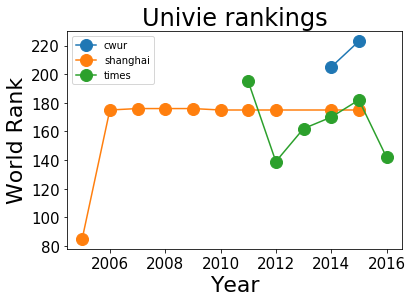

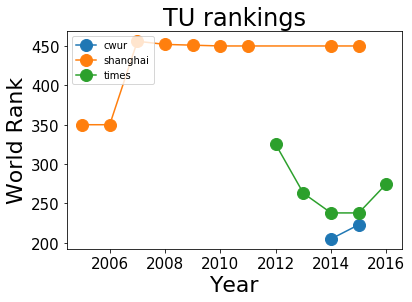

In [23]:
cwur_univie = cwur[cwur.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
cwur_univie['survey'] = "cwur"
times_univie = times[times.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
times_univie['survey'] = "times"
shanghai_univie = shanghai[shanghai.university_name.isin(["University of Vienna"])][['world_rank', 'year']]
shanghai_univie['survey'] = "shanghai"
all_surveys_univie = cwur_univie.append(times_univie).append(shanghai_univie)

cwur_TU = cwur[cwur.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
cwur_TU['survey'] = "cwur"
times_TU = times[times.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
times_TU['survey'] = "times"
shanghai_TU = shanghai[shanghai.university_name.isin(["Vienna University of Technology"])][['world_rank', 'year']]
shanghai_TU['survey'] = "shanghai"
all_surveys_TU = cwur_univie.append(times_TU).append(shanghai_TU)

groups_univie = all_surveys_univie.groupby('survey')

fig1, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups_univie:
    ax.plot(group.year, group.world_rank, marker='o', linestyle='-', ms=12, label=name)
    
ax.legend(loc=2,prop={'size':10})

plt.title("Univie rankings", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.ylabel("World Rank", fontsize=22)  
plt.xlabel("Year", fontsize=22)
plt.show()

groups_TU = all_surveys_TU.groupby('survey')

fig2, ax = plt.subplots()
ax.margins(0.05)

for name, group in groups_TU:
    ax.plot(group.year, group.world_rank, marker='o', linestyle='-', ms=12, label=name)
    
ax.legend(loc=2,prop={'size':10})

plt.title("TU rankings", fontsize=24)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)    
plt.ylabel("World Rank", fontsize=22)  
plt.xlabel("Year", fontsize=22)
plt.show()


fig1.savefig('graphs/tu_rank_graph', bbox_inches = 'tight')
fig2.savefig('graphs/tu_univie_rank_graph', bbox_inches = 'tight')

We can see that these rankings are quite different from survey to survey. Also, the time slices for which the data are given are different.

### 3.2 Overview over the CWUR dataset

The main goal here is to get an overview over the CWUR dataset. In particular, we are interested in the relationship between the different features and whether they correlate or not. For this we plot a heatmap of the correlation matrix as well as scatterplots of each variable combined with the world rank.

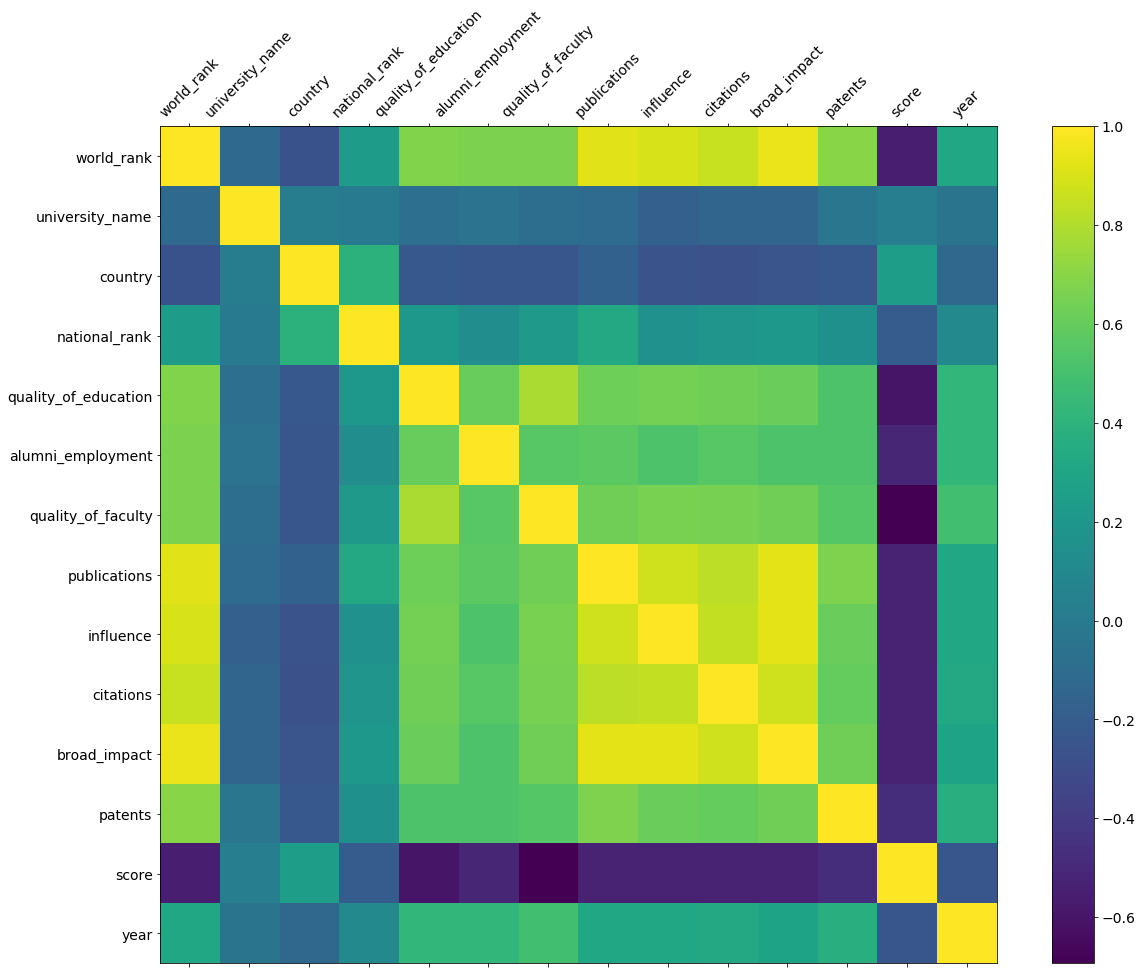

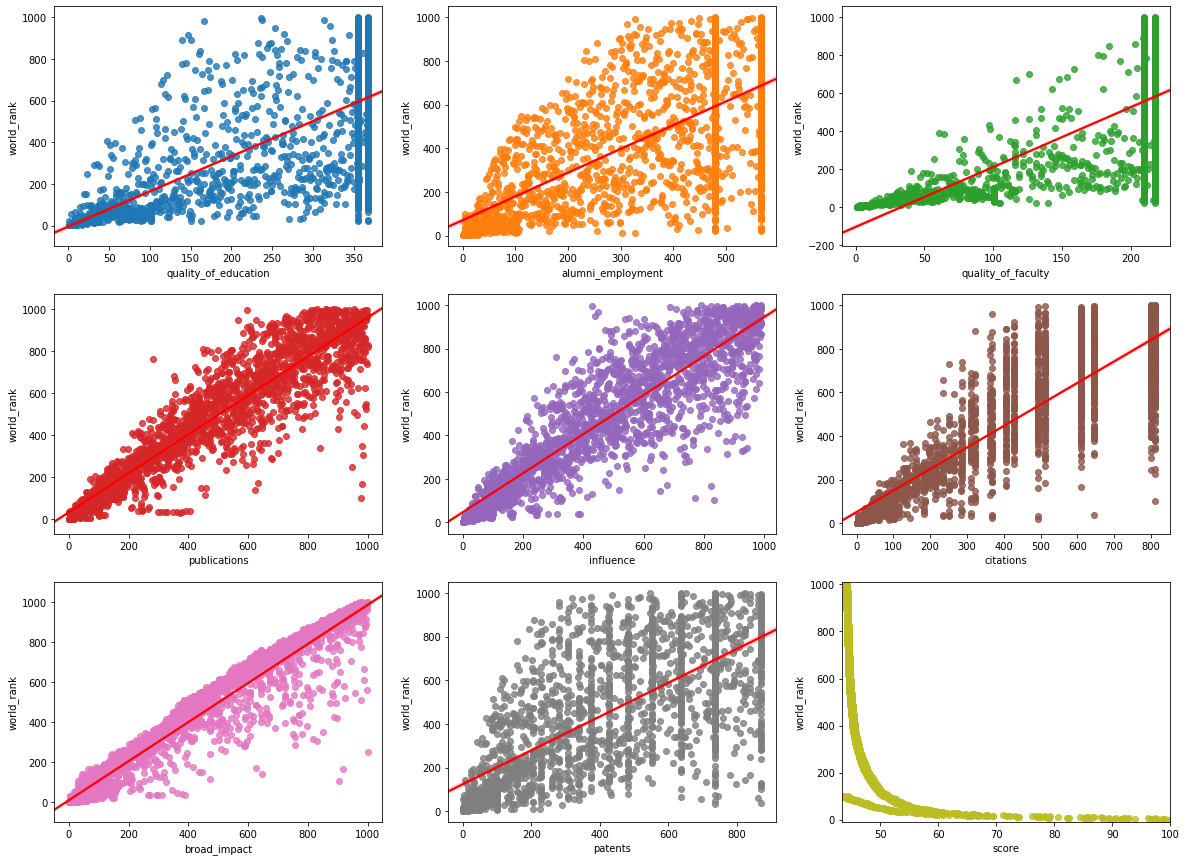

In [24]:
#Visualize Data

#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_imputed_enc.corr(), fignum=fig1.number)
plt.xticks(range(cwur_imputed_enc.shape[1]), cwur_imputed_enc.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_imputed_enc.shape[1]), cwur_imputed_enc.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#scatterplots vs. world rank

fig2, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 15))


sb.regplot(y='world_rank', x='quality_of_education', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[0,0])
sb.regplot(y='world_rank', x='alumni_employment', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[0,1])
sb.regplot(y='world_rank', x='quality_of_faculty', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[0,2])

sb.regplot(y='world_rank', x='publications', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[1,0])
sb.regplot(y='world_rank', x='influence', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[1,1])
sb.regplot(y='world_rank', x='citations', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[1,2])

sb.regplot(y='world_rank', x='broad_impact', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[2,0])
sb.regplot(y='world_rank', x='patents', data=cwur_imputed_enc,  line_kws = {'color':'red'}, ax=axs[2,1])
sb.regplot(y='world_rank', x='score', data=cwur_imputed_enc, ax=axs[2,2], fit_reg=False)
axs[2,2].set(xlim=(cwur_imputed_enc['score'].min(), cwur_imputed_enc['score'].max()))
axs[2,2].set(ylim=(cwur_imputed_enc['world_rank'].min()-10, cwur_imputed_enc['world_rank'].max()+10))

fig1.savefig('graphs/world_uni_hm.png', bbox_inches = 'tight')
fig2.savefig('graphs/rank_scatterplot.png', bbox_inches = 'tight')


We conclude, that social impact, influence and publications are the best motivators for a good ranking.

### 3.3 Analyzing changes in rankings

Also, we would like to investigate how the changes (i.e. differences) in the rankings are behaving and how they are related to changes of other features. For this we plot the boxplot of the rank differences and the heatmap of the correlation matrix of the differences.

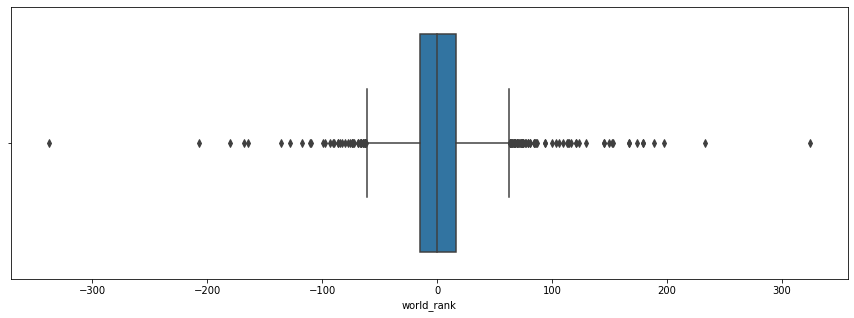

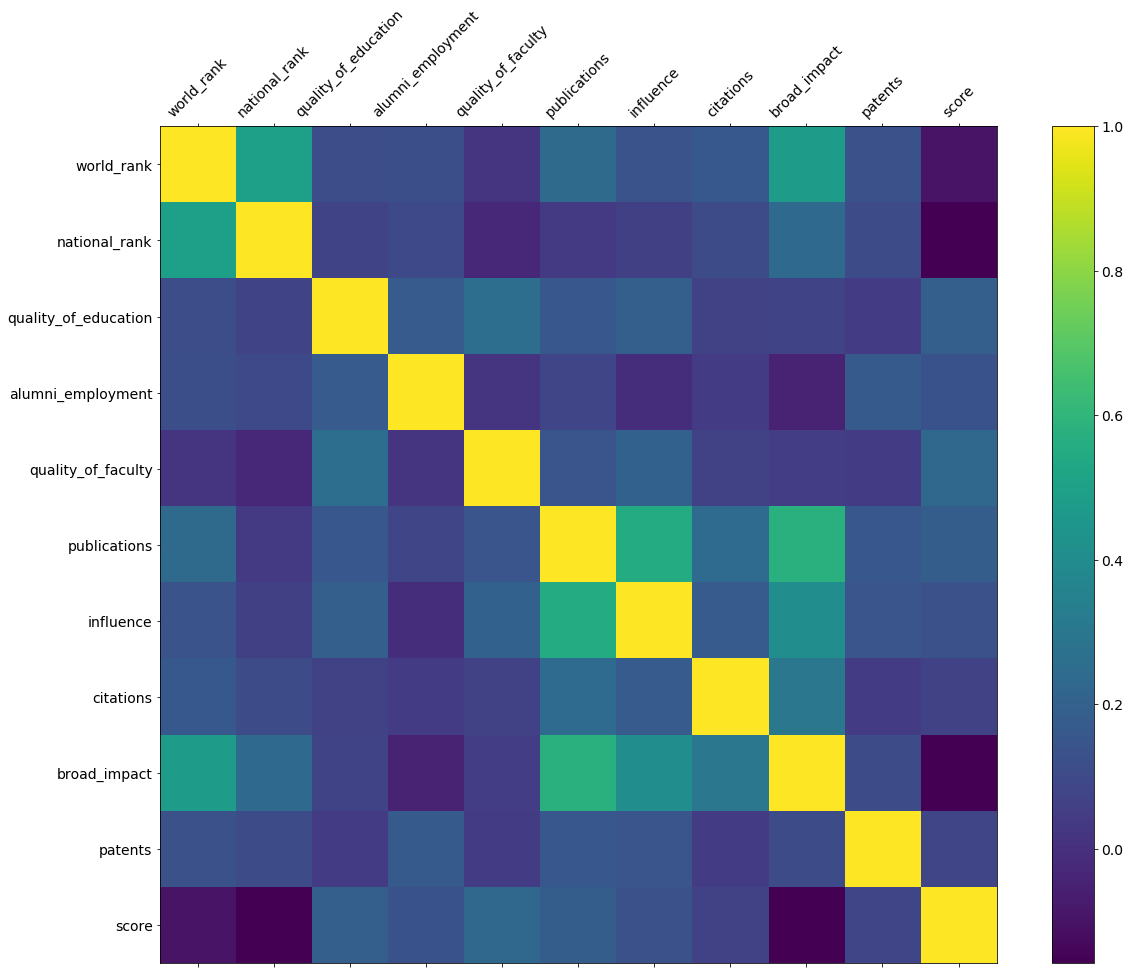

In [25]:
cwur_indexed = cwur_imputed.set_index(['year', 'university_name'])


cwur_diff = cwur_indexed.groupby(by='university_name').diff()


fig1 = plt.figure(figsize=(15, 5))
ax = sb.boxplot(x=cwur_diff['world_rank'])

#Heatmap
fig2 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_diff.corr(), fignum=fig2.number)
plt.xticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14, rotation=45)
plt.yticks(range(cwur_diff.shape[1]), cwur_diff.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)



fig1.savefig('graphs/world_rank_diff_bp.png', bbox_inches = 'tight')
fig2.savefig('graphs/world_rank_diff_corr.png', bbox_inches = 'tight')

Here we see, that when it comes to changes in rankings, there are many outliers, meaning unis make big leaps regarding uni rankings. On the other hand, the relatively small boxplot also shows, that certain university rankings rarely change over time. 

### 3.3 University rank and regional properties

In this part of the work, we would like to find out how regional properties of the universities' locations affect their rankings. The regional properties we analyzed include the countries' HDI (Human Development Index), the expenditures for public educational institutions (especially for higher education) in relation to the countries' GDP and also the abolute and relative (per capita) number of universities.

#### 3.3.1 Score by region

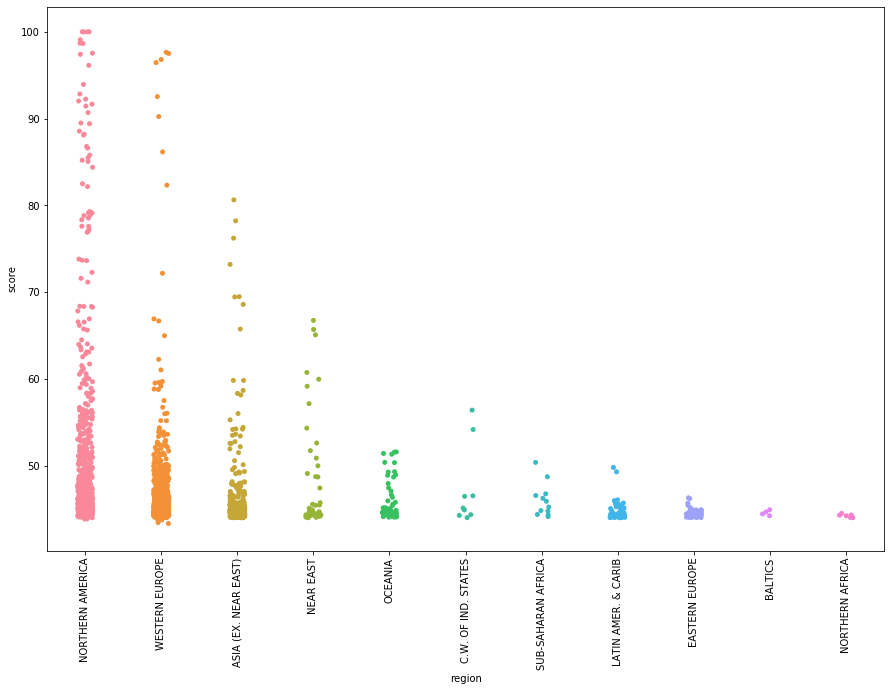

In [26]:
fig1 = plt.figure(figsize=(15, 10))

ax = sb.stripplot(x="region", y="score", data=cwur_countr_reg, jitter=True)
plt.xticks(rotation=90)

fig1.savefig('graphs/region_stripplot.png', bbox_inches = 'tight')

It is evident, that western countries simultaneously have more universities and fare better in terms of score.

#### 3.3.2 HDI

The mean ranking of all universties of a country is compared with the human development index of that country

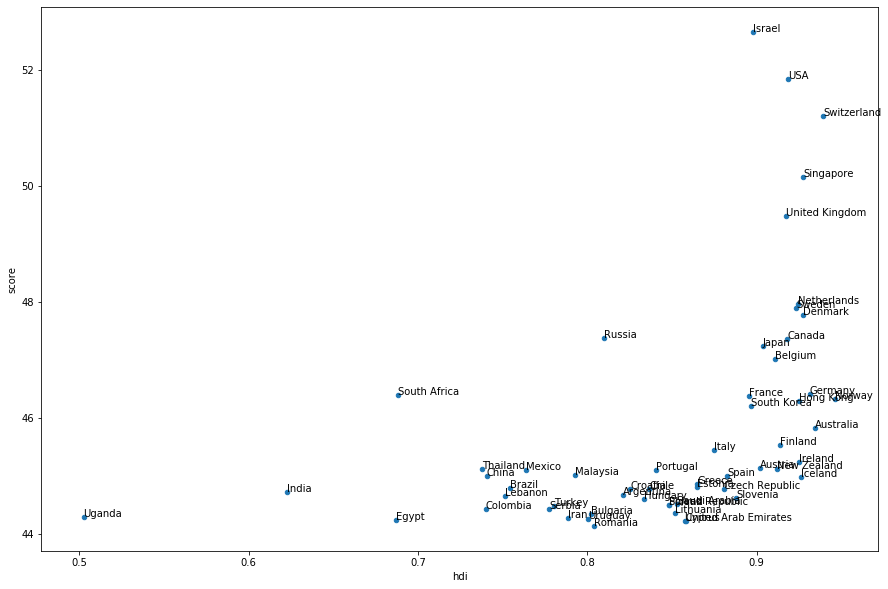

In [27]:
#check how HDI of countries correlates with rankings

#calculate mean world rank

cwur_hdi_mean = cwur_hdi.groupby("country").mean()

fig, ax = plt.subplots()
cwur_hdi_mean.plot("hdi", "score", kind="scatter",
             figsize = (15,10), ax=ax)

for k, v in cwur_hdi_mean.iterrows():
    x = v["hdi"]
    y = v["score"]
    ax.annotate(k, (x,y))
      
plt.show()

fig.savefig('graphs/hdi_score_scatter', bbox_inches = 'tight')



As expected, countries with a higher human development index also have a higher score.

#### 3.3.3 Public expenditures on education per country

We would like to find out how the expenditures for public education influences the rank of the universities of a country. Unfortuneatly, the data containing the expenditures and the data from the CWUR ranking have different time ranges. Therefore we will only group the data by country and look what effect a country's expenditures have on the mean and maximal score. (We also tried to do this for the minimal rank, but we then realized that the outcome has no value, as the worst universities are not even included in the rankings). This is done for the total expenditure (i.e. for all public institutions) as well as for higher education institutions only.

In the plots we also include a fitted regression line, once unweighted in red, and once the points representing the countries are weighted by the number of universities (in green). This is done because otherwise many countries with few universities may falsify the fitted line.

In [28]:
cwur.set_index(["year", "university_name"], inplace=True)

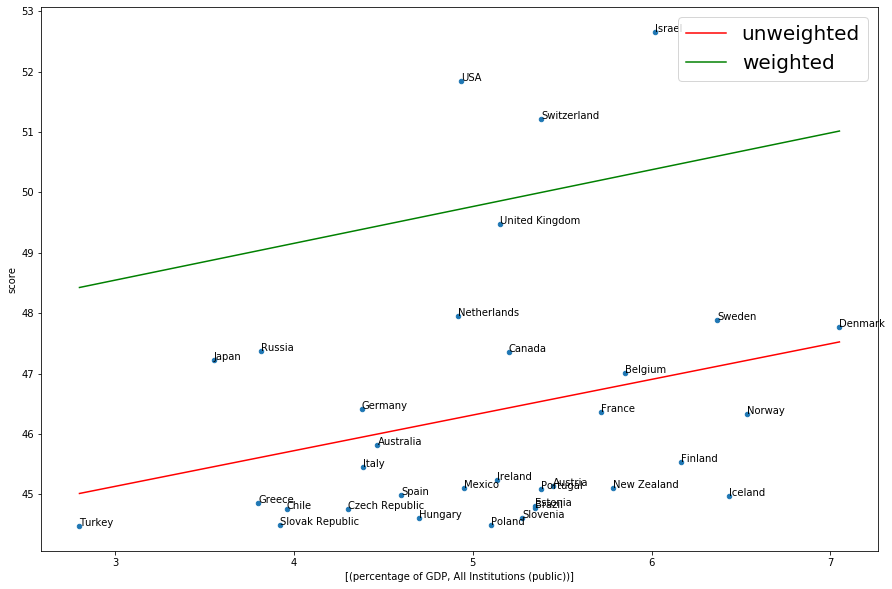

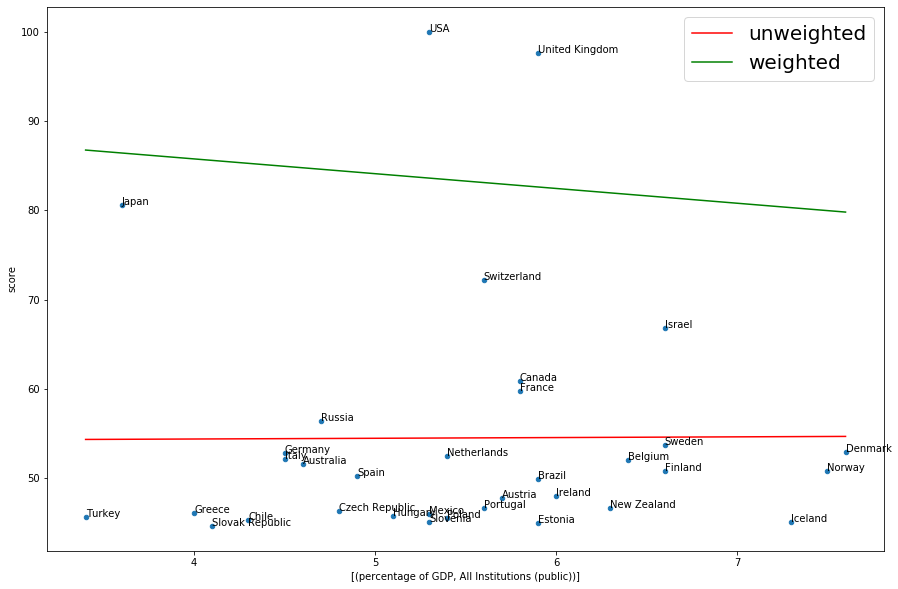

In [29]:
cwur2 = cwur_exp.groupby("country").mean()
cwur3 = cwur_exp.groupby("country").max()

fig1, ax = plt.subplots()

cwur2.plot([('percentage of GDP', 'All Institutions (public)')], "score", kind="scatter",
             figsize = (15,10), ax=ax)
x=cwur2[('percentage of GDP', 'All Institutions (public)')]
y=cwur2["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red", label = "unweighted")
b, m = polyfit(x,y, 1, w=cwur2["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green", label = "weighted")
plt.legend(prop={"size": 20})

for k, v in cwur2.iterrows():
    x = v[('percentage of GDP', 'All Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
    
plt.show()

fig2, ax = plt.subplots()
cwur3.plot([('percentage of GDP', 'All Institutions (public)')], "score", kind="scatter",
             figsize = (15,10), ax=ax)
x=cwur3[('percentage of GDP', 'All Institutions (public)')]
y=cwur3["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red", label = "unweighted")
b, m = polyfit(x,y, 1, w=cwur3["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green", label = "weighted")
plt.legend(prop={"size": 20})


for k, v in cwur3.iterrows():
    x = v[('percentage of GDP', 'All Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig1.savefig('graphs/exp_mean_all', bbox_inches = 'tight')
fig2.savefig('graphs/exp_max_all', bbox_inches = 'tight')

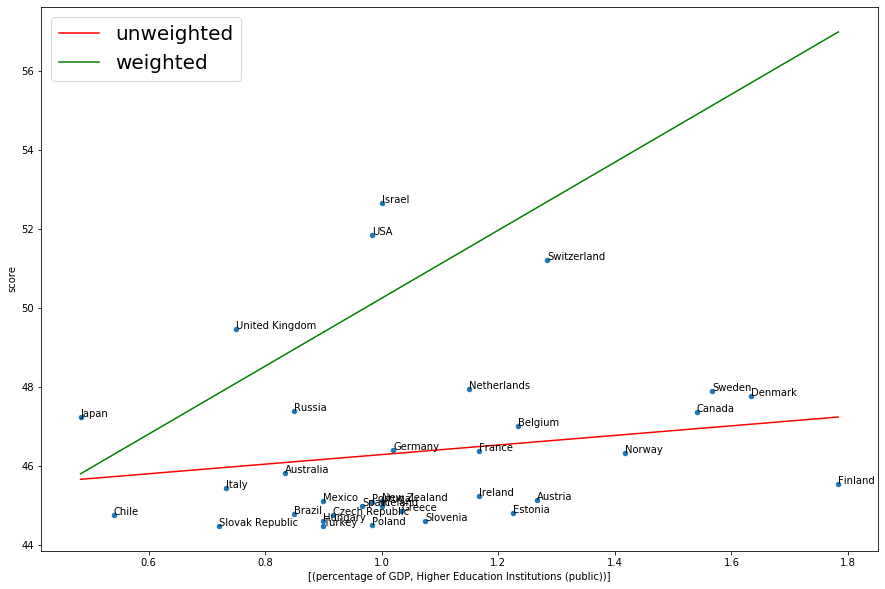

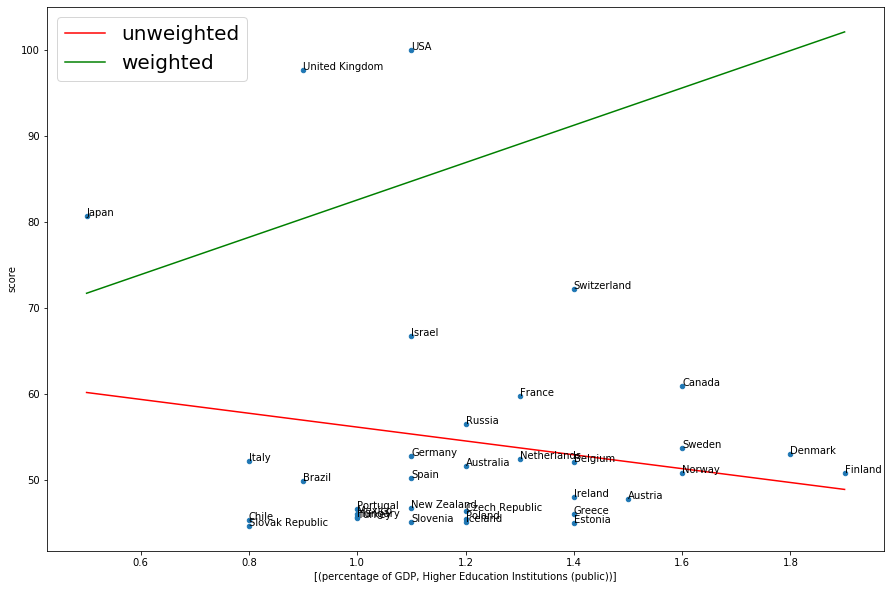

In [30]:
cwur2 = cwur_exp.groupby("country").mean()
fig1, ax = plt.subplots()

cwur2.plot([('percentage of GDP', 'Higher Education Institutions (public)')], "score", kind="scatter",
             figsize = (15,10), ax=ax)
x=cwur2[('percentage of GDP', 'Higher Education Institutions (public)')]
y=cwur2["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red", label = "unweighted")

b, m = polyfit(x,y, 1, w=cwur2["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green", label = "weighted")
plt.legend(prop={"size": 20})



for k, v in cwur2.iterrows():
    x = v[('percentage of GDP', 'Higher Education Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig2, ax = plt.subplots()
cwur3.plot([('percentage of GDP', 'Higher Education Institutions (public)')], "score", kind="scatter",
             figsize = (15,10), ax=ax)
x=cwur3[('percentage of GDP', 'Higher Education Institutions (public)')]
y=cwur3["score"]
b, m = polyfit(x,y, 1)
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="red", label = "unweighted")
b, m = polyfit(x,y, 1, w=cwur3["number of universities"])
plt.plot(x.sort_values(), b + m * x.sort_values(), '-', color="green", label = "weighted")
plt.legend(prop={"size": 20})

for k, v in cwur3.iterrows():
    x = v[('percentage of GDP', 'Higher Education Institutions (public)')]
    y = v["score"]
    ax.annotate(k, (x,y))
plt.show()

fig1.savefig('graphs/exp_mean_higher', bbox_inches = 'tight')
fig2.savefig('graphs/exp_max_higher', bbox_inches = 'tight')

These graphs confirm what was expected: the expenditures for education (in percent of the GDP) have an influence on the mean score of a country's universities. The more a country spends on education, the better the score will be. Looking at all expenditures or only on the expenditures for higher education yield similar results.

However, there seems to me no obvious relationship between a country's expenditure for education and the score of its best university.

We wanted to find out how the expenditures for education correlate with the score or with the world rank, and further more how they correlate with other features like influence, publications, citations, ... For this we plot a correlation heatmap.

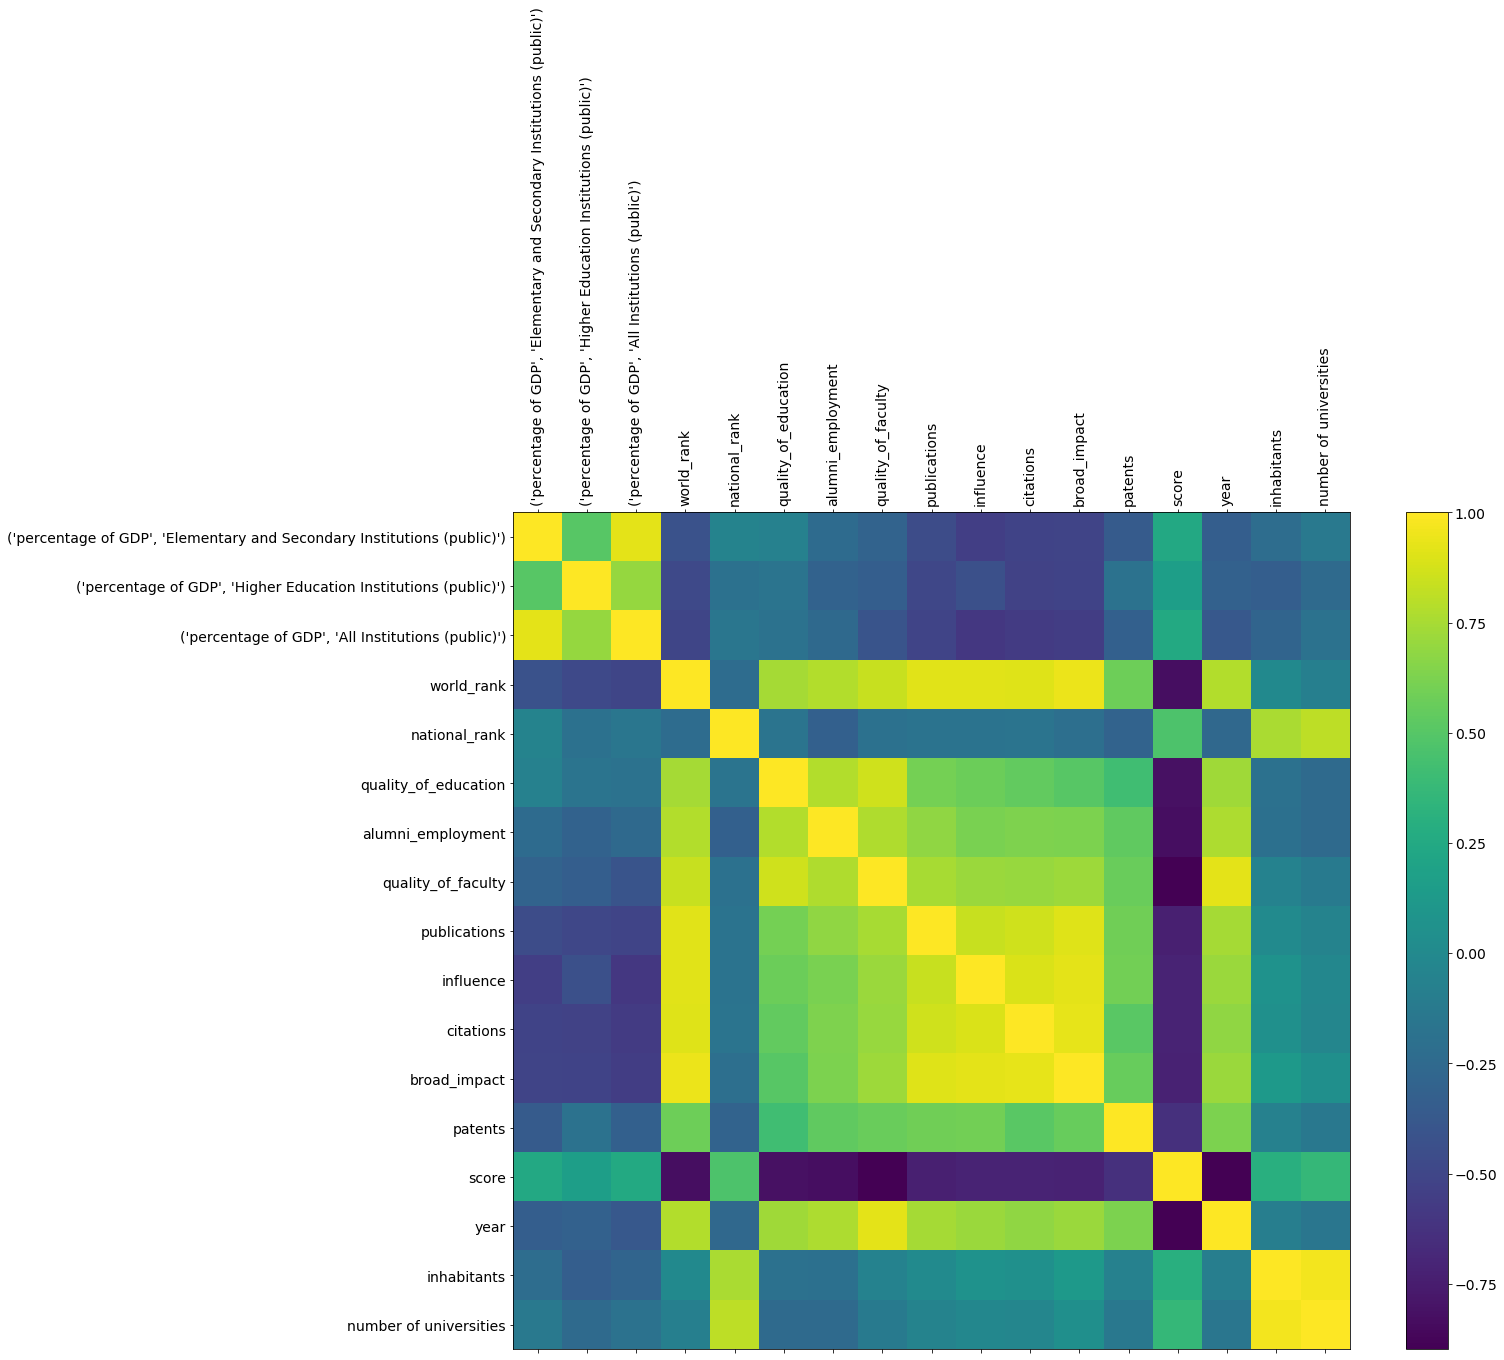

In [31]:
#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur2.corr(), fignum=fig1.number)
plt.xticks(range(cwur2.shape[1]), cwur2.columns, fontsize=14, rotation=90)
plt.yticks(range(cwur2.shape[1]), cwur2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

fig1.savefig('graphs/exp_corr', bbox_inches = 'tight')

This heatmap shows that the expenditures for education correlate rather negatively with the world rank, which is quite natural, as the rank decreases when more money is invested in education. The correlation with the score is not that pronounced as it is for the world rank.

One can also see that the expenditures for education have more or less a negative correlation with features like influence, publications, citations. This was also expected, as those features are given as a rank, where lower values indicate a better score.

#### 3.3.4 Inhabitants, number of universities and number of universities per inhabitant

In this section, we would like to find out how the number of inhabitants, the number of universities and their ratio influences the mean score of a country's university. For the number of universities, we only found the most acutal data (from 2018), so that a time-dependent analysis was not possible. Again the mean of the university's score was taken over all years available in the CWUR dataset to be more independent from outliers.

As above, we show scatterplots of the mean score and the country's feature in question. The plot is again accompanied by a weighted (by number of universities) and unweighted linear regression. It is also important to note that logarithmic scales where used when appropriate, so that the dependencies can be seen in a clear way.

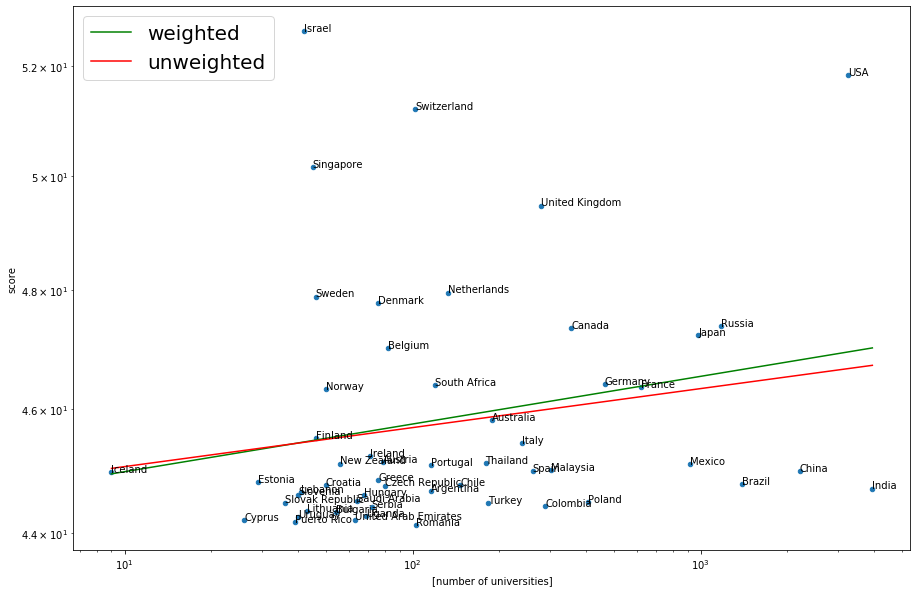

In [32]:
cwur_inh2 = cwur_inh.groupby("country").mean()
cwur_inh2["universities per inhabitant log"] = np.log(cwur_inh2["universities per inhabitant"])
cwur_inh2["inhabitants log"] = np.log(cwur_inh2["inhabitants"])
cwur_inh2["universities log"] = np.log(cwur_inh2["number of universities"])
cwur_inh2["score log"] = np.log(cwur_inh2["score"])


fig, ax = plt.subplots()
cwur_inh2.plot([('number of universities')], "score", kind="scatter",
             figsize = (15,10), ax=ax)


ax.set_xscale('log')
ax.set_yscale('log')

x=np.log(cwur_inh2[("number of universities")])
y=np.log(cwur_inh2["score"])
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()), np.exp(b + m * x.sort_values()), '-', color="green", label = "weighted")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()), np.exp(b + m * x.sort_values()), '-', color="red", label = "unweighted")
plt.legend(prop={"size": 20})


for k, v in cwur_inh2.iterrows():
    x = v['number of universities']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

fig.savefig('graphs/uni_num_mean', bbox_inches = 'tight')

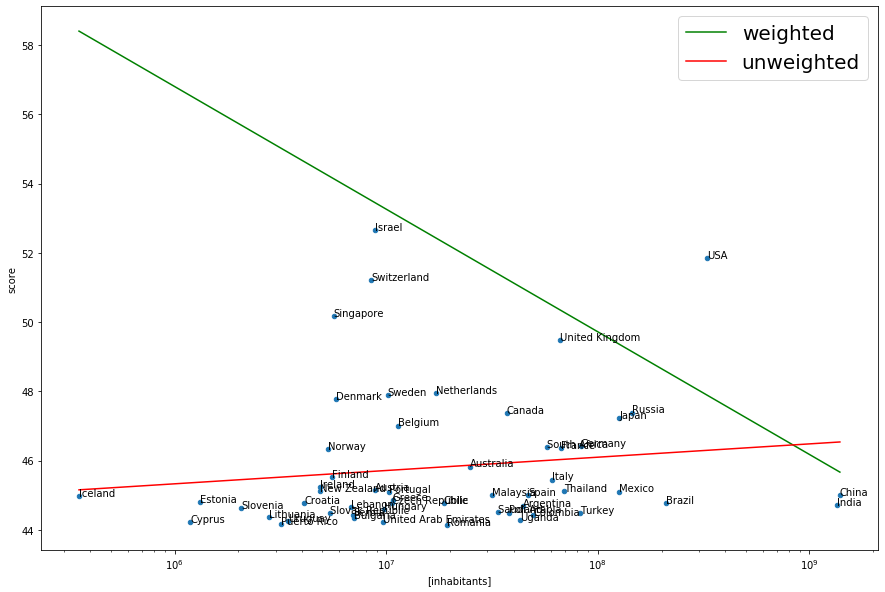

In [33]:
cwur_inh2 = cwur_inh.groupby("country").mean()
fig, ax = plt.subplots()
cwur_inh2.plot([('inhabitants')], "score", kind="scatter",
             figsize = (15,10), ax=ax)
ax.set_xscale('log')
#ax.set_yscale('log')

x=np.log(cwur_inh2[("inhabitants")])
y=cwur_inh2["score"]
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()), b + m * x.sort_values(), '-', color="green", label = "weighted")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()), b + m * x.sort_values(), '-', color="red", label = "unweighted")
plt.legend(prop={"size": 20})


for k, v in cwur_inh2.iterrows():
    x = v['inhabitants']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

fig.savefig('graphs/inh_num_mean', bbox_inches = 'tight')

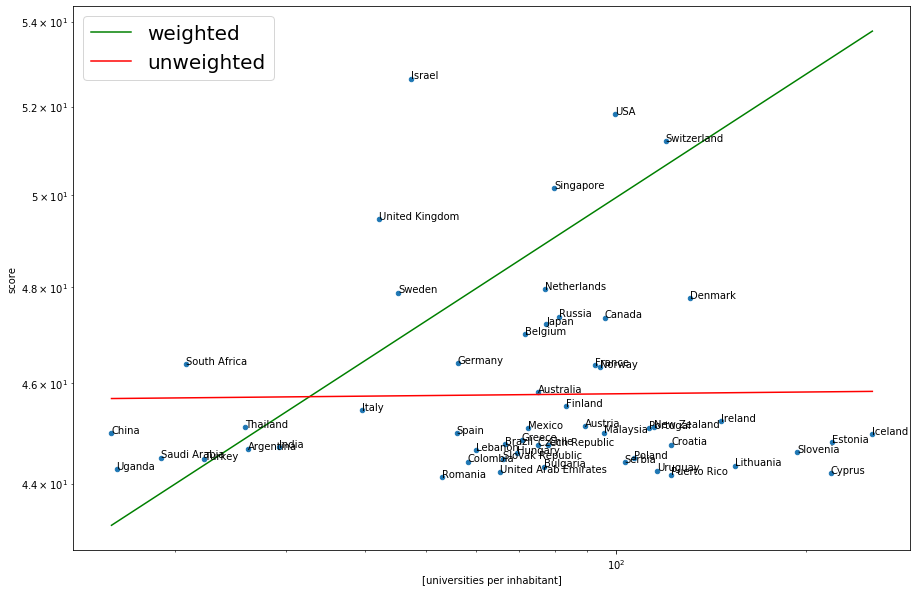

In [34]:
cwur_inh2 = cwur_inh.groupby("country").mean()
fig, ax = plt.subplots()

cwur_inh2.plot([('universities per inhabitant')], "score", kind="scatter",
             figsize = (15,10), ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')

x=np.log(cwur_inh2[("universities per inhabitant")])
y=np.log(cwur_inh2["score"])
# b, m = polyfit(x,y, 1, w = np.log(cwur_inh2["number of universities"]))
b, m = polyfit(x,y, 1, w = cwur_inh2["number of universities"])
plt.plot(np.exp(x.sort_values()),np.exp(b + m * x.sort_values()), '-', color="green", label = "weighted")
b, m = polyfit(x,y, 1)
plt.plot(np.exp(x.sort_values()),np.exp(b + m * x.sort_values()), '-', color="red", label = "unweighted")
plt.legend(prop={"size": 20})


for k, v in cwur_inh2.iterrows():
    x = v['universities per inhabitant']
    y = v["score"]
    ax.annotate(k, (x,y))

plt.show()

fig.savefig('graphs/uni_inh_num_mean', bbox_inches = 'tight')

From these three plots we conclude that the number of universities in a country may only have a slight impact on the score.

The number of inhabitants seems to be no indicator for the score of the universities in this country. This conclusion is also rather intuitive.

In the last graph, we can see why weighted regression is acutally important. When looking at the points only, one can see a tred that when the ratio of universities per inhabitant is higher, then also the score will be higher. However many small similar countries such as Slovenia, Estonia, Cyprus, Island, Lithuania, etc. pull down the red regression line and falsify the result of the trend line. The weighted line (green) indicates what we have seen first by looking at the points only: the more universities per capita there are, the better the score will be (with some exceptions like the ones mentioned before).

As before, we look how these features correlate with the score and the rank as well as with the other features by showing a heatmap. It is expected that the correlation results are mediocre, as we often looked at logarithmic scales.

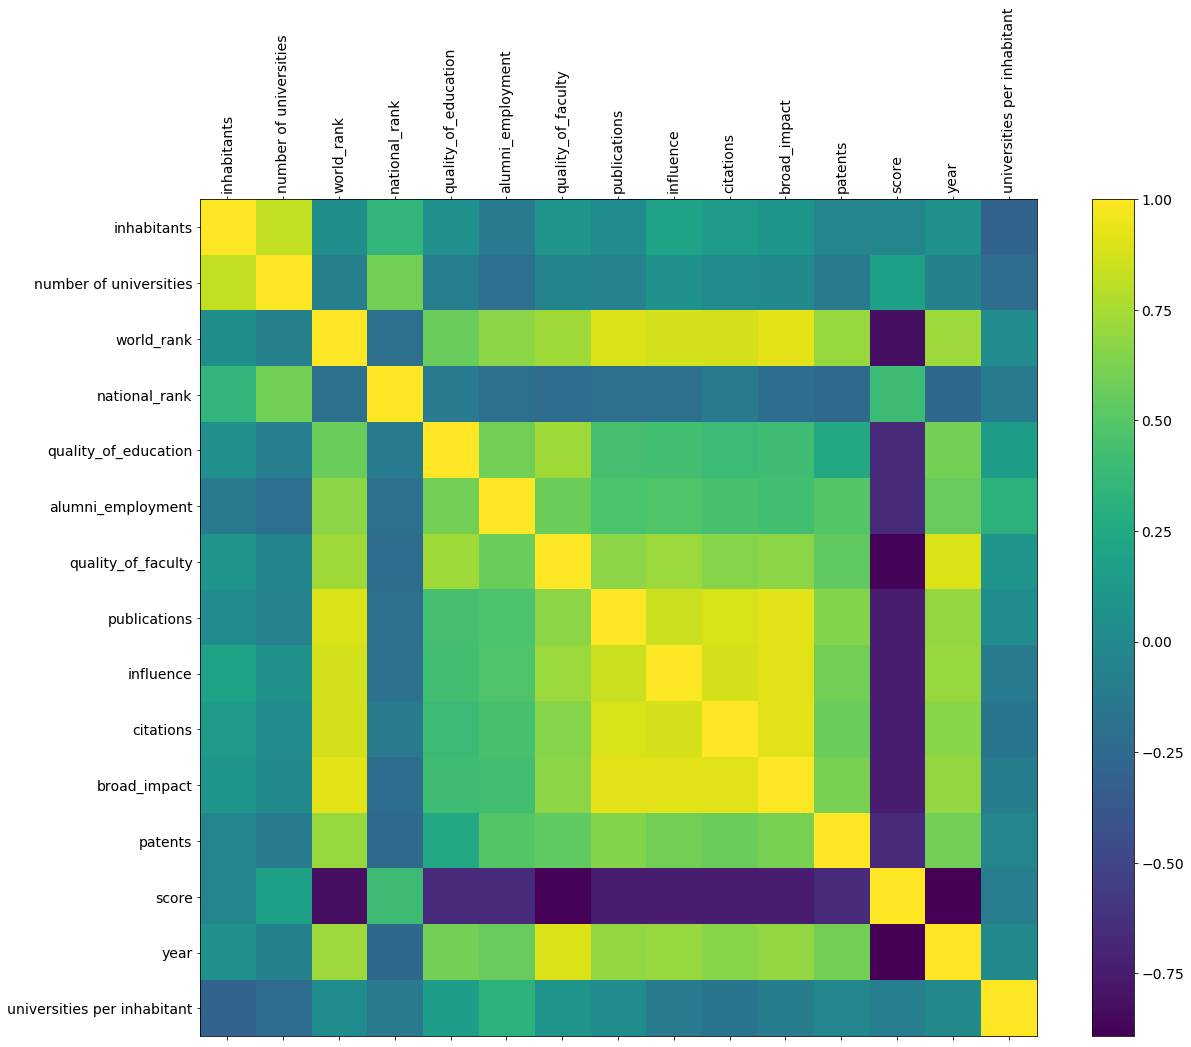

In [35]:
#Heatmap
fig1 = plt.figure(figsize=(20, 15))
plt.matshow(cwur_inh2.corr(), fignum=fig1.number)
plt.xticks(range(cwur_inh2.shape[1]), cwur_inh2.columns, fontsize=14, rotation=90)
plt.yticks(range(cwur_inh2.shape[1]), cwur_inh2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

fig.savefig('graphs/uni_inh_corr', bbox_inches = 'tight')

We see what was expected, the correlations are mediocre.

#### 3.3.5 Corruption Perceptions Index and rankings by region

Corruption, which is an inherent characteristic of a country, is taken into account to analyse whether changes in a corruption measure can be used as a predictor for changes in university rankings.

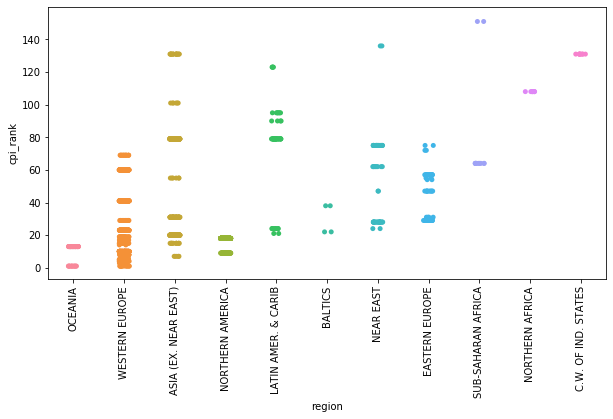

In [36]:
#plot country by region and ranking
fig = plt.figure(figsize=(10, 5))
sb.stripplot(x="region", y="cpi_rank", data=cwur_cpi_reg, jitter=True)
plt.xticks(rotation=90)

fig.savefig('graphs/cpi_region_stripplot', bbox_inches = 'tight')

In [37]:
fig = plt.figure(figsize=(10, 5))
#correlation between corruption preceptions index and university properties
corr = cwur_cpi_reg.corr()
corr.style.background_gradient(cmap='coolwarm')

,cpi_rank,year,cpi_score,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
cpi_rank,1,0.12388,-0.968316,0.393995,-0.17717,0.245182,0.220535,0.260676,0.300245,0.47462,0.389219,0.437357,0.331203,-0.19422
year,0.12388,1,-0.0886936,0.323237,0.106502,0.426295,0.42871,0.484197,0.320094,0.318618,0.329249,0.289979,0.383993,-0.240117
cpi_score,-0.968316,-0.0886936,1,-0.389345,0.170875,-0.250198,-0.221588,-0.250578,-0.286353,-0.47319,-0.395752,-0.428456,-0.311589,0.1864
world_rank,0.393995,0.323237,-0.389345,1,0.24131,0.68485,0.66641,0.671843,0.923435,0.899569,0.860421,0.954139,0.712976,-0.548826
national_rank,-0.17717,0.106502,0.170875,0.24131,1,0.223955,0.138503,0.232482,0.33446,0.1715,0.196223,0.219274,0.147428,-0.202978
quality_of_education,0.245182,0.426295,-0.250198,0.68485,0.223955,1,0.611523,0.783667,0.62908,0.644739,0.63147,0.612731,0.560986,-0.603562
alumni_employment,0.220535,0.42871,-0.221588,0.66641,0.138503,0.611523,1,0.562146,0.566066,0.52094,0.554144,0.519761,0.546488,-0.508126
quality_of_faculty,0.260676,0.484197,-0.250578,0.671843,0.232482,0.783667,0.562146,1,0.639593,0.657443,0.654615,0.634172,0.583842,-0.696436
publications,0.300245,0.320094,-0.286353,0.923435,0.33446,0.62908,0.566066,0.639593,1,0.874442,0.829647,0.92932,0.693715,-0.520818
influence,0.47462,0.318618,-0.47319,0.899569,0.1715,0.644739,0.52094,0.657443,0.874442,1,0.842439,0.928032,0.647137,-0.52124


<Figure size 720x360 with 0 Axes>

## Step 4: Model the data

#### 4.1 Predicting CWUR score using HDI

We use a characteristic of the country itself, to predict how well the universities of that country do. For that, we first take a dataset consisting of mean scores of universities by country. We then use that data as the data to be predicted and HDI as a predictor to predict the mean score of these countries.

In [38]:
hdi_score = cwur_hdi_mean[[ 'hdi', 'score']]


# y is the actual data we want to predict
y = np.array(hdi_score['score'])

#drop data we want to predict from table
x= hdi_score.drop(('score'), axis = 1)

# Convert to numpy array
x = np.array(x)

# Save feature names for visualization later
feature_list = list(hdi_score.columns)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 101)

print('Training Features Shape:', train_x.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_x.shape)
print('Testing Labels Shape:', test_y.shape)
#hdi_score

Training Features Shape: (45, 1)
Training Labels Shape: (45,)
Testing Features Shape: (12, 1)
Testing Labels Shape: (12,)


In [39]:
#train model

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 123)

#fit model
rf.fit(train_x, train_y)


#predict
pred = rf.predict(test_x)

In [40]:
#check performance metrics

#calculate mean error to see how much our average estimate is off by
print('Mean Absolute Error:', round(np.mean(abs(pred - test_y)), 2), 'score points.')

#r2 score (might not be representative of accuracy due to small number rows)
rf.score(pred.reshape(-1,1),test_y.reshape(-1,1))





Mean Absolute Error: 1.46 score points.


-0.17091936180191736

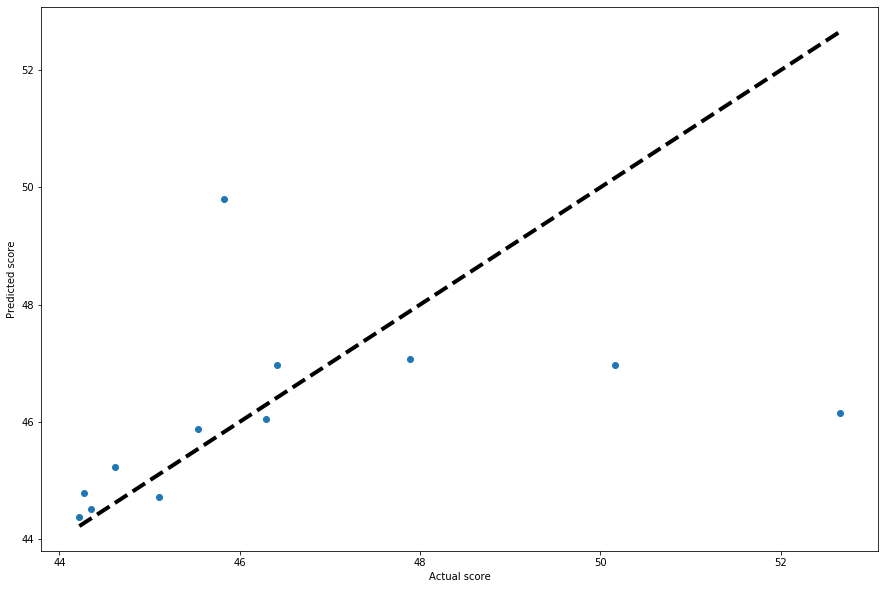

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(test_y, pred)
ax.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Actual score')
ax.set_ylabel('Predicted score')
plt.show()

fig.savefig('graphs/pred_hdi_uniscore', bbox_inches = 'tight')

We see that the error lies within about 1.5 ranks. This means that our model can accurately predict the average rank of universities of a country. We see that our dataset is quite small. This is due to the fact, because we first grouped the ranks of our universities by country, reducing our dataset to about 60 rows. As a result, we did not have much test data to play  with.

### 4.2 Predicting times-score

Now, we build a model to predict the total score in the times dataframe. For this, we only consider the top 200 ranks of each year, as in the lower rankings many missing values occur. For prediction, we use the features number of students, student-staff-ratio, percentage of international students, percentage of female students.

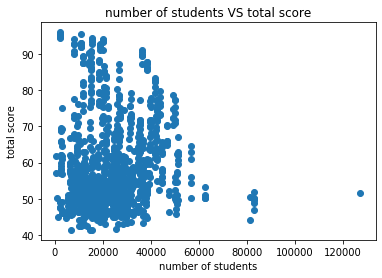

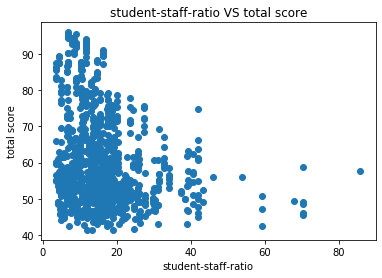

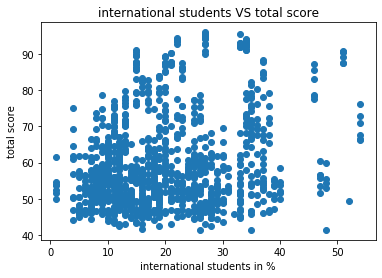

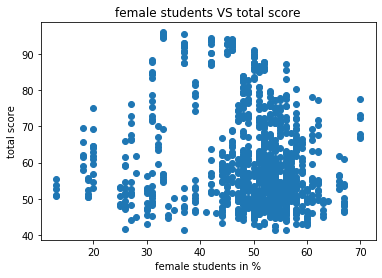

In [42]:
#we only consider top 200 because in worse ranks the total_score is mostly missing
times_top200 = times[times.world_rank <= 200][['world_rank', 'university_name', 'country', 'total_score', 'num_students', 'student_staff_ratio', 'international_students', 'female_male_ratio']]

#drop rows with NANs
times_top200 = times_top200.dropna(subset=['num_students', 'student_staff_ratio', 'international_students', 'female_male_ratio'])

#get rid of ',' within the numbers
times_top200['num_students'] = times_top200['num_students'].str.replace(',','')
#get rid of the % symbol and rename column
times_top200['international_students'] = times_top200['international_students'].apply(lambda x : re.sub("[^0-9]", "", str(x)))
times_top200 = times_top200.rename({'international_students' : 'international_students_percentage'}, axis='columns')
#replace female_male_ratios by female_percentage
ratios = times_top200['female_male_ratio'].unique()
ratio_to_percentage = {}
for ratio in ratios:
    parts = ratio.split(':')
    ratio_to_percentage[ratio] = parts[0]
times_top200 = times_top200.replace({"female_male_ratio": ratio_to_percentage})
times_top200 = times_top200.rename({'female_male_ratio' : 'female_percentage'}, axis='columns')
#cast columns
times_top200 = times_top200.astype({'total_score': 'float', 'num_students': 'int', 'international_students_percentage' : 'int', 'female_percentage' : 'int'})


plt.scatter(times_top200['num_students'], times_top200['total_score'])
plt.title("number of students VS total score")
plt.xlabel("number of students")
plt.ylabel("total score")
plt.show()
plt.scatter(times_top200['student_staff_ratio'], times_top200['total_score'])
plt.title("student-staff-ratio VS total score")
plt.xlabel("student-staff-ratio")
plt.ylabel("total score")
plt.show()
plt.scatter(times_top200['international_students_percentage'], times_top200['total_score'])
plt.title("international students VS total score")
plt.xlabel("international students in %")
plt.ylabel("total score")
plt.show()
plt.scatter(times_top200['female_percentage'], times_top200['total_score'])
plt.title("female students VS total score")
plt.xlabel("female students in %")
plt.ylabel("total score")
plt.show()

In the above plots we cannot see strong correlations between the total score and the chosen university-properties. The student-staff-ratio seems to have the most correlation. Next, we build a model using random forest.

Absolute mean error of predictions: 3.3781415768259535
For comparisson, absolute mean error when simply predicting the mean of the training sample for every observation in the testing set: 10.279736094979999


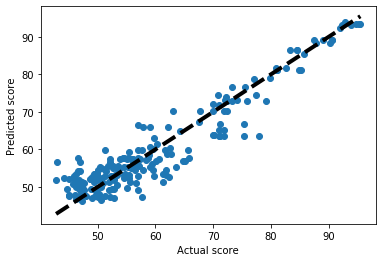

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = times_top200.drop(columns=['total_score', 'world_rank', 'university_name', 'country'])
y = times_top200['total_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

regressor = RandomForestRegressor(n_estimators=100, random_state=123)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

ame = np.mean(abs(y_pred - y_test))
ame_test = np.mean(abs(np.mean(y_train) - y_test))
print('Absolute mean error of predictions: ' + str(ame))
print('For comparisson, absolute mean error when simply predicting the mean of the training sample for every observation in the testing set: ' + str(ame_test))

fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual score')
ax.set_ylabel('Predicted score')
plt.show()

#plt.scatter(y_pred, y_test)

fig.savefig('graphs/pred_uniFeatures_unirank', bbox_inches = 'tight')

It seems like the model is predicting the total score very well. Lets see which features contributes the most to the predictions:

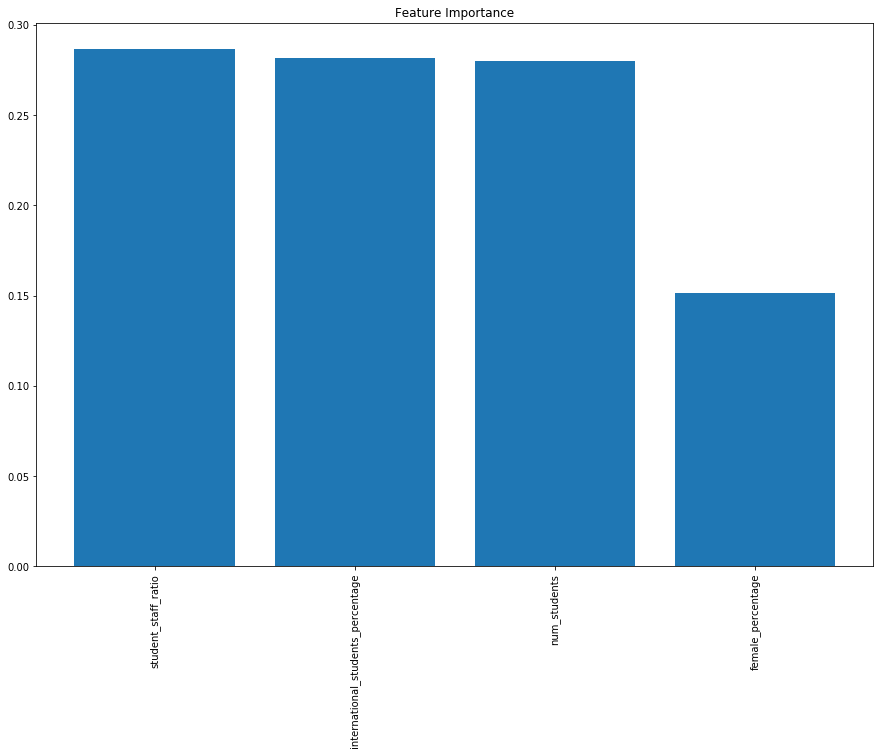

In [44]:
#store importance
importances = regressor.feature_importances_
#visualize

indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]


fig = plt.figure(figsize=(15,10))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

fig.savefig('graphs/featureImportance_pred_uniFeatures', bbox_inches = 'tight')

It seems like the percentage of female students is not as relevant while the other three features are more or less equally important.

## Conclusion

First of all, the different datasets of the rankings were very messy: they contained a lot of missing values; there were a bunch of typos within the countries and university names; missing values were reffered to in many different ways (NAN, -, ?, 0,...); there were random symbols attached to some numbers, etc. So one major part of our work was to preprocess the data.

Then, we noticed that there are huge differences in rankings between the three surveys. So, for example, when we compare the rankings with some properties of the corresponding countries, the amount of correlation depends strongly on the survey we choose for comparison. Hence, our first idea was to combine the surveys into one dataframe with the average rankings. However, most universities had slightly different names throughout the different surveys which made it hard to merge the data. As we were not able to solve this issue with regular expressions, we tried to do it by hand - after doing this for quite a while we decided to not finish the replacement as that would have taken probably days without educational benefit. This step might be indispensable for a serious publication though.

For the reasons mentioned above, we focused more on exploring and visualizing the data than building models with ML-algorithms. We got insight on how different universities changed over time according to the different surveys and which characteristics contribute most to the rankings. We visualized the correlation between country properties like public expenditure for education, corruption perceptions index and the average university ranking of the country. Finally, we fitted some ML-models - one to predict the average university ranking of a country given its HDI and one to predict the times-university-score given university-features like student-staff-ratio.

Overall we were able to see how tedious it can be to work with 'dirty' data, how hard that makes it to fit useful models and therefore the importance of data cleaning and preprocessing.